In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
from einops import rearrange
import os
os.chdir('/project/lcd_v2')
from run.tools.cli.infer import prepare_inference
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


plt.style.use('bmh')

['/run', '', '/usr/lib/python3.9/site-packages', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/tmp/tmpq341is1h', '/project/lcd_v2/run', '/project/lcd_v2/run/external']


In [22]:
root_dir = 'work_dir/'
step_limit = 400

In [77]:
# helper function
def normalization(x, eps=1e-6):
        x = abs(x)
        # rescale gradients to between 0 and 1
        flatin = x.reshape((x.size(0),-1))
        temp, _ = flatin.min(1, keepdim=True)
        x = x - temp.unsqueeze(1)

        flatin = x.reshape((x.size(0),-1))
        temp, _ = flatin.max(1, keepdim=True)
        x = x / (temp.unsqueeze(1) + eps)
        return x

def get_input_gradient(model, objective, x):
    model.zero_grad()
    input_gradients = torch.autograd.grad(outputs=objective, inputs=x)[0]
    return input_gradients

def get_gradient_saliency(model, sample):
    x, y = copy.deepcopy(sample)
    x = {k: torch.tensor(v).unsqueeze(0).cuda() for k, v in x.items()}
    x['seq'].requires_grad_()
    model.eval()
    prob = model(x)
    objective = -1. * F.nll_loss(prob, y.cuda().flatten(), reduction='sum')
    input_gradient = get_input_gradient(model, objective, x['seq'])
    input_gradient = rearrange(input_gradient, 'b l c -> b c l')
    gradient = normalization(input_gradient).cpu()
    gradient = rearrange(gradient, 'b c l -> b l c')
    return {'seq':x['seq'], 'confidence': prob.softmax(dim=-1)[0, 1], 'gt': y, 'gradient': gradient.squeeze().reshape(-1, 2)}

class GradCAM1d(GradCAM):
    def get_cam_weights(self, input_tensor, target_layer, target_category, activations, grads):
        return np.mean(grads, axis=1)

    def scale_cam_image(self, cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = np.interp(np.linspace(0, target_size, target_size), np.linspace(0, target_size, len(img)), img)
            result.append(img)
        result = np.float32(result)

        return result

    def get_target_length(self, input_tensor):
        length = input_tensor.size(-2)
        return length

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      targets,
                      activations,
                      grads,
                      eigen_smooth=False):

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None] * np.transpose(activations, (0, 2, 1))
        cam = np.transpose(weighted_activations, (0, 2, 1)).sum(axis=-1)
        return cam

    def compute_cam_per_layer(
            self,
            input_tensor,
            targets,
            eigen_smooth):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_length(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

def get_cam_plots(target_idxs, mi, dl, axes=None, shift=False, default_shift='backward', save_dir=None):
    target_layers = [mi.model.backbone.layers[1].norm1]
    cam = GradCAM1d(model=mi, target_layers=target_layers, use_cuda=True)
    if axes is None:
        fig, axes = plt.subplots(round(len(target_idxs)/3), 3, figsize=(24, round(len(target_idxs)/3)*4))

    cls = ['#DE1334', '#6752FF', '#0B2735']
    for i, ax in enumerate(axes.flatten()):
        if shift:
            if isinstance(dl.dataset[target_idxs[i]][0], np.ndarray):
                input_tensor = torch.tensor(dl.dataset[i][0]).unsqueeze(0).cuda()
            else:
                input_tensor = dl.dataset[target_idxs[i]][0].clone().unsqueeze(0).cuda()
            if default_shift == 'forward':
                input_tensor[:, :, 1] = torch.cat((input_tensor[0, 0, 1].reshape(1, 1, 1).tile(1, step_limit, 1), input_tensor[:, :-step_limit, 1].unsqueeze(-1)), dim=1).squeeze()
            elif default_shift == 'backward':
                input_tensor[:, :, 1] = torch.cat((input_tensor[:, step_limit:, 1].unsqueeze(-1), input_tensor[0, -1, 1].reshape(1, 1, 1).tile(1, step_limit, 1)), dim=1).squeeze()
            else:
                raise ValueError('default_shift must be either forward or backward')
        else:
            input_tensor =  torch.tensor(dl.dataset[target_idxs[i]][0]).unsqueeze(0).cuda()
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
        ax.plot(dl.dataset[target_idxs[i]][0][:, 0], c=cls[0], linestyle='-', label='cause')
        ax.plot(dl.dataset[target_idxs[i]][0][:, 1], c=cls[1], linestyle='--', label='result')
        ax.plot(grayscale_cam.squeeze(), c=cls[2], label='grad_cam')
        confidence = mi(input_tensor).softmax(dim=-1)[:, 1].detach().cpu().numpy()[0]
        label = int(target_idxs[i] in pos_samples)
        if shift:
            ax.set_title(f'Original Label: {label} | Current Label: {int(label==0)} | Prediction: {int(confidence>0.5)}', fontdict={'family': 'Serif'})
        else:
            ax.set_title(f'Label: {label} | Prediction: {int(confidence>0.5)}', fontdict={'family': 'Serif'})
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc='lower right', prop={'family': 'Serif'}, labelcolor='black')

    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")


### Gradient Saliency

In [51]:
# get result from deep learning method
cfgs = [
        'mos6502_transformer_128/mos6502_transformer_128.py',
        ]
ckpts = [
         'mos6502_transformer_128/ckpts/exp_name=mos6502_transformer_128-cfg=mos6502_transformer_128-bs=512-seed=42-val_average_precision=0.5373.ckpt',
         ]
cfgs, ckpts = [root_dir + cfg for cfg in cfgs], [root_dir + ckpt for ckpt in ckpts]

di, mi = prepare_inference(cfgs[0], ckpts[0])
mi = mi.cuda()
# di.data_cfg.test.split = '.cache/sim_data/DonkeyKong/HR/window_768_1024/csv/fold_seed_42/test_ds_1.0.csv'
di.setup('test')
dl = di.test_dataloader()

# get result from noise injection
di_noise, mi_noise = prepare_inference(cfgs[0], ckpts[0])
mi_noise = mi_noise.cuda()
# di_noise.data_cfg.test.split = '.cache/sim_data/DonkeyKong/HR/window_768_1024/csv/fold_seed_42/test_ds_1.0.csv'
di_noise.data_cfg.test.data_root = '.cache/sim_data/DonkeyKong/HR/window_768_1024/Regular_3510_step_256_rec_400_window_768_1024_Noise_0.5.npy'
di_noise.setup('test')
dl_noise = di_noise.test_dataloader()


# cfgs = [
#         'patch_transformer_128_fold_seed_42/patch_transformer_128_fold_seed_42.py',
#         ]
# ckpts = [
#          'patch_transformer_128_fold_seed_42/ckpts/exp_name=patch_transformer_128_fold_seed_42-cfg=atch_transformer_128_fold_seed_42-bs=256-seed=42-val_auroc=0.8231.ckpt',
#          ]
# cfgs, ckpts = [root_dir + cfg for cfg in cfgs], [root_dir + ckpt for ckpt in ckpts]
#
# di_noise, mi_noise = prepare_inference(cfgs[0], ckpts[0])
# mi_noise = mi_noise.cuda()
# di_noise.setup()
# dl_noise = di_noise.test_dataloader()

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [68]:
# get positive samples
df = pd.read_csv(di.data_cfg.train.split)
df = df.sample(frac=1).reset_index(drop=True)
pos_samples = np.where(df['label']==1)[0]

### GradCAM

In [69]:
df[df['label']==1]

,id,transistor_1,transistor_2,file_path,label
3,3107877,1928,2839,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
4,4527291,2802,769,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
6,4976004,3059,3134,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
7,3550270,2258,2936,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
8,4978580,3060,3358,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
...,...,...,...,...,...
115562,4970394,3057,1986,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
115565,1986051,1222,518,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
115566,2023588,1262,2719,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1
115567,4975715,3059,2737,.cache/sim_data/DonkeyKong/HR/window_256_512/R...,1


/tmp/ipykernel_3069/4117494861.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor =  torch.tensor(dl.dataset[target_idxs[i]][0]).unsqueeze(0).cuda()


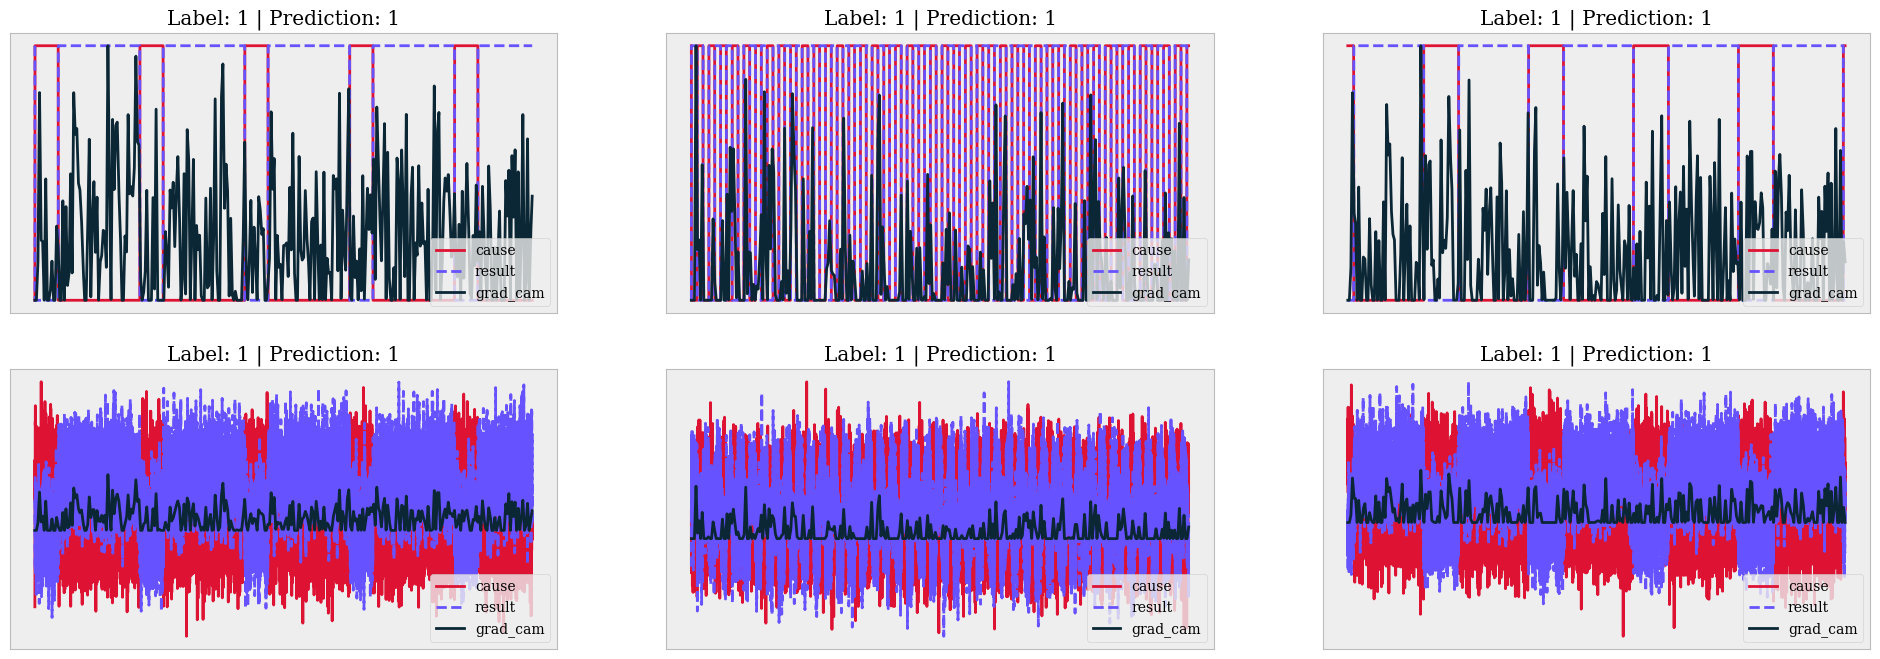

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
target_idxs = pos_samples[:3].tolist()
get_cam_plots(target_idxs, mi, dl, axes.flatten()[:3])
get_cam_plots(target_idxs, mi_noise, dl_noise, axes.flatten()[3:6])
# fig.savefig('/home/charon/project/nmos_inference/figures/Figure 5. CAM/cam_supplement.svg')

FileNotFoundError: [Errno 2] No such file or directory: '/home/charon/project/nmos_inference/figures/Figure 5. CAM/reverse.svg'

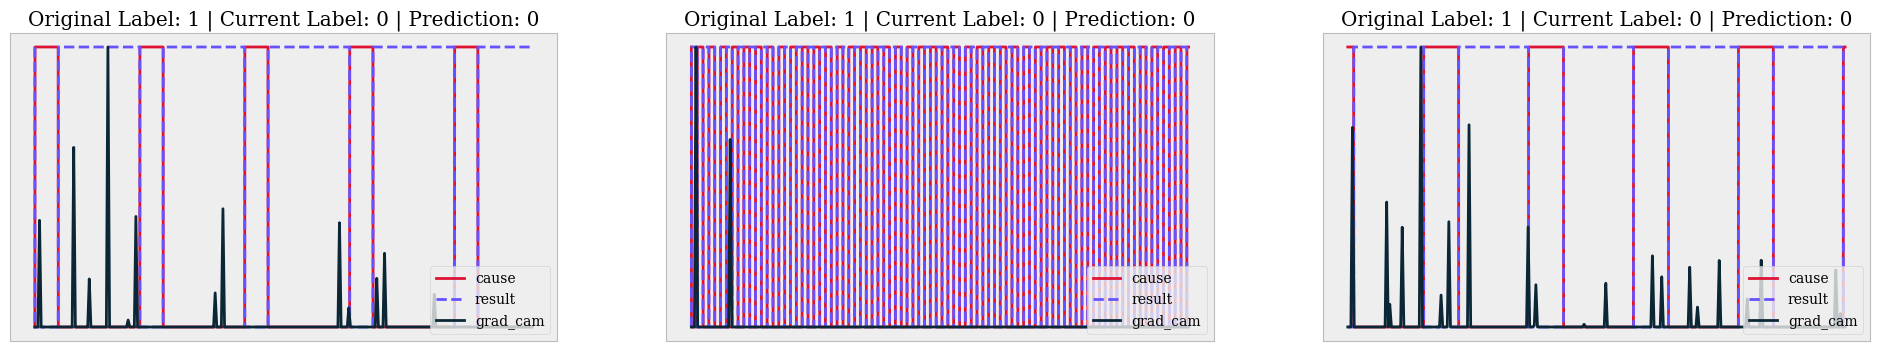

In [79]:
get_cam_plots(target_idxs, mi, dl, shift=True, default_shift='forward', save_dir='/home/charon/project/nmos_inference/figures/Figure 5. CAM/reverse')